# Uncapacitated facility location

Wir implementieren hier das Ganzzahlprogramm für uncapacitated facility location:

$$
\begin{array}{lll}
\min & \sum_{i\in\mathcal F}y_if_i
+\sum_{i\in\mathcal F,j\in\mathcal D}x_{ij}c_{ij}, 
& y\in\mathbb R^{\mathcal F},\, x\in\mathbb R^{\mathcal F\times\mathcal D}\\
\textrm{unter} & x_{ij}\leq y_i & \textrm{für alle }i\in\mathcal F,\,j\in\mathcal D\\
& \sum_{i\in\mathcal F}x_{ij}\geq 1 & \textrm{für alle }j\in\mathcal D\\
& x_{ij}\in\{0,1\},\,y_i\in\{0,1\} & \textrm{für alle }i\in\mathcal F,\,j\in\mathcal D
\end{array}
$$


Verwendet wird das <code>mip</code>-Paket. Dokumentation findet sich [hier.](https://python-mip.readthedocs.io/en/latest/)

In [1]:
# Zum Installieren in google colab, entfernen Sie die Raute in der nächsten Zeile
#!pip install mip

import mip  ## Bibliothek für lineare Programme und MIPs
import numpy as np ## Standard-Bibliothek für wiss Rechnen
import random
import math
import matplotlib.pyplot as plt
### Wir benutzen das fivethirtyeight style, damit die plots ein bisschen hübscher aussehen
### könnte auch weggelassen werden
plt.style.use('fivethirtyeight')

Wie immer brauchen wir eine Beispielsinstanz, die wir zufällig erzeugen. Wir platzieren Standorte und Kunden zufällig in der Ebene. Als Anschluss-/Betriebskosten nehmen wir dann den gewöhnlichen Abstand in der Ebene. Die Konstruktionskosten setzen wir überall auf $1$.

In [2]:
def rnd_instance(num_facilities=10,num_customers=30):
    facilities=[(random.random(),random.random()) for _ in range(num_facilities)]
    customers=[(random.random(),random.random()) for _ in range(num_customers)]
    opening_costs=[1]*num_facilities  ## for simplicity, all opening costs are 1
    return facilities,customers,opening_costs

def distance(facility,customer):
    px,py=facility
    qx,qy=customer
    return math.sqrt((px-qx)**2+(py-qy)**2)

facilities,customers,opening_costs=rnd_instance()

Ein bisschen Visualisierungscode. Der ist ein wenig komplizierter, aber nicht notwendig, um das MIP bzw dessen Lösung zu verstehen. Dh, einfach ignorieren. 

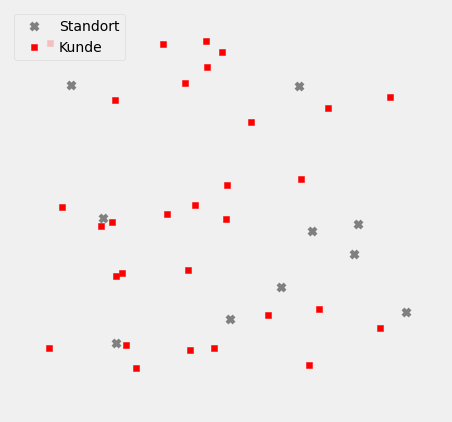

In [3]:
def show(facilities,customers,x=None,y=None):
    plt.figure(figsize=(7,7))
    BB=np.array(facilities)
    CC=np.array(customers)
    if y is None:
        closed=BB
    else:
        opened=np.array([F for i,F in enumerate(facilities) if y[i].x==1])
        closed=np.array([F for i,F in enumerate(facilities) if y[i].x==0])
        plt.scatter(opened[:,0],opened[:,1],color='blue',s=100,marker='o',label="offen")
    plt.scatter(closed[:,0],closed[:,1],color='gray',s=50,marker='x',label="Standort")
    plt.scatter(CC[:,0],CC[:,1],color='red',marker='s',label="Kunde")
    if x is not None:
        for i in range(len(facilities)):
            for j in range(len(customers)):
                if x[i][j].x>0.0001:
                    plt.plot([BB[i,0],CC[j,0]],[BB[i,1],CC[j,1]],'k',zorder=-1,alpha=0.5,linewidth=2)
    plt.xlim(-0.1,1.1)
    plt.ylim(-0.1,1.1)
    plt.xticks([])
    plt.yticks([])
    plt.legend(loc="upper left")
    plt.show()   

show(facilities,customers)

## Das MIP

Wir starten damit, das <code>Model</code> zu instantiieren. 

In [4]:
m=mip.Model()
num_customers=len(customers)
num_facilities=len(facilities)

Binäre Variablen werden erzeugt, in dem var_type=mip.BINARY gesetzt wird. 

$y_i\in\{0,1\}$

In [5]:
y=[m.add_var(var_type=mip.BINARY) for _ in range(num_facilities)]

Als nächstes erzeugen wir die Anschlussvariablen.

$x_{ij}\in\{0,1\}$

In [6]:
x=[[m.add_var(var_type=mip.BINARY) for _ in range(num_customers)] for _ in range(num_facilities)]

Die Zielfunktion. Als Anschluss-/Betriebkosten nehmen wir den Abstand in der Ebene.

$\min\sum_{i}y_if_i+\sum_{ij}x_{ij}c_{ij}$

In [7]:
m.objective=mip.minimize(mip.xsum(y[i]*opening_costs[i] for i in range(num_facilities)) + \
                         mip.xsum(x[i][j]*distance(facilities[i],customers[j]) for i in range(num_facilities) for j in range(num_customers)))

Die Indikatorvariablebedingungen -- kein Anschluss zu einer nicht geöffneten facility:

$x_{ij}\leq y_i$

In [8]:
for i in range(num_facilities):
    for j in range(num_customers):
        m+=x[i][j]<=y[i]

Jeder Kunde muss angeschlossen werden:

$\sum_{i}x_{ij}\geq 1$ 

In [9]:
for j in range(num_customers):
    m+=mip.xsum(x[i][j] for i in range(num_facilities)) >= 1

Wir starten die Optimierung und lassen uns gleich die Lösung anzeigen:

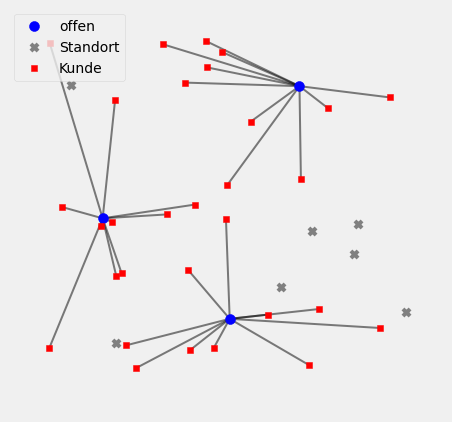

In [10]:
m.optimize()

show(facilities,customers,x,y)